### train mnist

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import torch

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        net = models.mobilenet_v3_small(pretrained=False)
        
        self.trunk = nn.Sequential(*(list(net.children())[:-2]))
        
        
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Sequential(
            nn.Linear(576, 10, bias=True),
            nn.LogSoftmax(dim=1)
        )
        

    def forward(self, x):
        
        x = self.trunk(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings

    no_cuda = False
    seed = 1111
    batch_size = 128
    test_batch_size = 1000
    lr = 0.01
    save_model = True
    epochs = 2
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': batch_size,'shuffle':True}
    test_kwargs = {'batch_size': test_batch_size,'shuffle':True}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': False}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    dataset2 = datasets.ImageFolder('mnist/testing',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs, num_workers=8)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    #model = Net().to(device)
    model = MobileNet().to(device)
        
    optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=lr)

    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    for epoch in range(1, epochs + 1):
        train( model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "mnist_mobile.pt")
    
    
    return model



In [242]:
m1 = main()

[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.370431
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.233302
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.090256
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.096215
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.162110

Test set: Average loss: 1.8990, Accuracy: 6366/10000 (64%)



[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.103508
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.092841
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.043678
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.101000
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.105290

Test set: Average loss: 0.1027, Accuracy: 9680/10000 (97%)



### how's our model

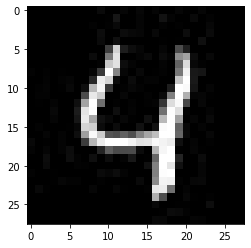

In [173]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

four_img = Image.open("mnist/pic/4.jpg")
four_img = four_img.convert('RGB')
transform=transforms.Compose([
        transforms.ToTensor()  
        ])

norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])


four_tensor = transform(four_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(four_tensor[0].numpy().transpose(1,2,0))


In [175]:

def cnn_eval(tensor):
    model=Net()
    model.load_state_dict(torch.load("mnist_cnn.pt"))
    model.eval()
    print(torch.argmax(model(tensor)))

def mobile_eval():
    model=MobileNet()
    model.load_state_dict(torch.load("mnist_mobile.pt"))
    model.eval()
    print(torch.argmax(model(tensor)))

cnn_eval(norm(four_tensor))

tensor(4)


### attack 

0 -0.00027843413408845663
10 -0.00036864637513644993
20 -0.000530936405993998
30 -0.0009389282786287367
40 -0.005393952131271362


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True class probability: tensor([[1.7309e-05, 1.0312e-05, 7.8416e-05, 7.1383e-06, 5.0086e-01, 9.9547e-05,
         6.0964e-05, 9.8617e-05, 6.2249e-04, 4.9815e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)


tensor([[[[-9.9668e-03,  2.2291e-02,  4.6719e-02,  ...,  1.3192e-02,
            1.1618e-03,  2.8219e-03],
          [-1.1786e-02, -2.5912e-02,  2.3099e-02,  ...,  8.0967e-02,
            4.6469e-02,  2.7213e-02],
          [ 5.1958e-03,  8.7876e-04, -5.7875e-02,  ..., -5.1395e-02,
           -8.5129e-03,  1.9210e-02],
          ...,
          [-3.8500e-02,  2.9278e-02,  6.1664e-02,  ..., -2.7753e-02,
            4.1060e-02,  2.1239e-02],
          [-2.4087e-02,  1.5330e-02,  8.7136e-02,  ..., -1.3800e-02,
            2.6018e-02,  1.6525e-02],
          [-8.9572e-04, -1.4769e-02, -3.4753e-02,  ..., -9.7952e-03,
            5.6025e-03,  2.4200e-03]],

         [[ 8.5576e-05,  3.5396e-02,  6.9976e-02,  ...,  3.3757e-02,
            5.7173e-02,  1.7350e-02],
          [-2.1830e-02, -6.6800e-03, -7.7745e-03,  ...,  6.3465e-02,
            8.3985e-02,  2.3346e-02],
          [ 5.6941e-02,  6.9236e-02, -1.1356e-02,  ...,  3.2948e-02,
            1.4232e-02,  1.0141e-02],
          ...,
     

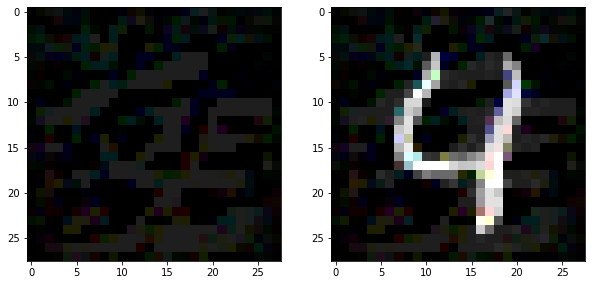

In [189]:
import torch.optim as optim


def l_infinity_pgd(model, tensor, gt,epsilon=30./255, target=None,iter=50, show=True):
    delta = torch.zeros_like(tensor, requires_grad=True)
    opt = optim.SGD([delta], lr=10)

    for t in range(iter):
        pred = model(norm(tensor + delta))
        if target is None:
            loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]))
        else:
            loss = loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]))
            + nn.CrossEntropyLoss()(pred, torch.LongTensor([target]))
        if t % 10 == 0:
            print(t, loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        delta.data.clamp_(-epsilon, epsilon)

    print("True class probability:", nn.Softmax(dim=1)(pred))
    cnn_eval(norm(tensor+delta))

    if show:
        f,ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].imshow((delta)[0].detach().numpy().transpose(1,2,0))
        ax[1].imshow((tensor + delta)[0].detach().numpy().transpose(1,2,0))
    
    return tensor + delta

x= l_infinity_pgd(model,four_tensor,4)

## targeted 

tensor(7)


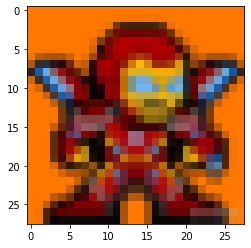

In [180]:
import torch.optim as optim

rem_img = Image.open("mnist/pic/tienan.jpeg")
rem_img = rem_img.convert('RGB')
transform=transforms.Compose([
    transforms.Resize((28,28))  ,
        transforms.ToTensor()  
        ])

norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])


rem_tensor = transform(rem_img)[None,:,:,:]
cnn_eval(norm(rem_tensor))
plt.imshow(rem_tensor[0].numpy().transpose(1,2,0))


0 -1.4144344329833984
10 -4.362909317016602
20 -4.3939924240112305
30 -4.355737209320068
40 -4.522609710693359
50 -4.478915214538574
60 -4.5059051513671875
70 -4.521789073944092
80 -4.450867652893066
90 -4.565112113952637
100 -4.562137603759766
110 -4.580658912658691
120 -4.442877292633057
130 -4.567966938018799
140 -4.573883056640625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True class probability: tensor([[0.0499, 0.0325, 0.2303, 0.0177, 0.0718, 0.1054, 0.2238, 0.0095, 0.2270,
         0.0321]], grad_fn=<SoftmaxBackward>)
tensor(6)


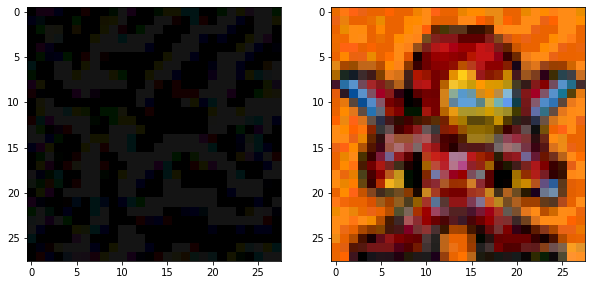

In [186]:

import torch.optim as optim

l_infinity_pgd(model,rem_tensor,7,20./255,6,150)

### 生成对抗数据

In [193]:
# create dataset
import os
from torchvision.utils import save_image
def create_adv_dataset():
    transform=transforms.Compose([
        transforms.ToTensor()
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,batch_size=1, shuffle=True, num_workers=8)
    
    attack_target = 0 
    for batch_idx, (data, target) in enumerate(train_loader):
        attack_target = batch_idx//100
        if target== attack_target:
            continue
        if attack_target>9:
            break
        model=Net()
        model.load_state_dict(torch.load("mnist_cnn.pt"))
        model.eval()
        adv_img = l_infinity_pgd(model,data,target,35./255,attack_target,50,False)
        image_dir_1 = os.path.join('mnist/adv_ori_label',str(target.item()))
        image_dir_2 = os.path.join('mnist/adv_adv_label',str(attack_target))
        if not os.path.exists(image_dir_1):
            os.makedirs(image_dir_1)
        if not os.path.exists(image_dir_2):
            os.makedirs(image_dir_2)
        
        save_image(adv_img, os.path.join(image_dir_1,str(batch_idx)+'.jpg'))
        save_image(adv_img, os.path.join(image_dir_2,str(batch_idx)+'.jpg'))

create_adv_dataset()    

[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

0 -1.6569954823353328e-05
10 -1.6689160474925302e-05
20 -1.6927575416048057e-05
30 -1.7165990357170813e-05
40 -1.7404405298293568e-05
True class probability: tensor([[4.1913e-11, 1.2179e-11, 5.4419e-13, 1.3069e-05, 1.9263e-10, 9.9998e-01,
         6.8287e-09, 1.7835e-11, 2.6321e-09, 4.4743e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
0 -2.1934269170742482e-05
10 -2.253030106658116e-05
20 -2.3007127310847864e-05
30 -2.372236667724792e-05
40 -2.4318398573086597e-05
True class probability: tensor([[6.6042e-11, 1.4568e-09, 7.2572e-10, 7.5952e-07, 4.0406e-07, 8.0367e-08,
         9.4437e-13, 1.8178e-05, 5.5577e-06, 9.9998e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
0 -5.4834770708112046e-05
10 -5.61460001335945e-05
20 -5.769562994828448e-05
30 -5.900685573578812e-05
40 -6.031808152329177e-05
True class probability: tensor([[1.7770e-07, 9.9994e-01, 8.2749e-07, 9.8480e-07, 3.3876e-05, 3.3331e-07,
         1.4693e-05, 7.8703e-06, 2.4207e-06, 4.9970e-07]],
       grad_fn=<SoftmaxBa

True class probability: tensor([[5.6226e-07, 1.4721e-05, 1.7924e-05, 9.1191e-01, 8.1496e-07, 8.7782e-02,
         6.1879e-06, 1.1558e-05, 6.4459e-05, 1.9535e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0 -0.0031484817154705524
10 -1.4947314262390137
20 -3.261176824569702
30 -3.4277172088623047
40 -3.4669148921966553
True class probability: tensor([[1.8069e-05, 2.7527e-03, 8.8127e-03, 3.2175e-03, 1.3909e-04, 4.7406e-04,
         1.2775e-05, 1.5013e-03, 9.5598e-01, 2.7091e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
0 -1.9430925021879375e-05
10 -2.002696055569686e-05
20 -2.062299427052494e-05
30 -2.109982233378105e-05
40 -2.1576648578047752e-05
True class probability: tensor([[7.0623e-09, 3.1939e-07, 5.0203e-07, 6.2960e-09, 9.9998e-01, 1.3703e-07,
         9.8424e-06, 4.5500e-07, 3.5382e-07, 1.0365e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
0 -1.311301275563892e-06
10 -1.311301275563892e-06
20 -1.311301275563892e-06
30 -1.311301275563892e-06
40 -1.311301275563892e-06


30 -2.2236175537109375
40 -2.242387533187866
True class probability: tensor([[1.6472e-04, 1.2129e-04, 4.5124e-03, 2.4034e-02, 4.9349e-04, 8.4353e-01,
         1.2668e-03, 4.9065e-04, 2.0041e-02, 1.0534e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
0 -0.00013124081306159496
10 -0.0001399419124936685
20 -0.0001494772732257843
30 -0.00016044282529037446
40 -0.00017307691450696439
True class probability: tensor([[2.4181e-07, 9.9981e-01, 3.0044e-07, 1.7823e-06, 1.3369e-04, 8.9225e-07,
         2.9556e-05, 6.4825e-06, 1.2584e-05, 5.9229e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
0 -2.0265373677830212e-05
10 -2.038458114839159e-05
20 -2.0503786799963564e-05
30 -2.074220174108632e-05
40 -2.0861407392658293e-05
True class probability: tensor([[3.2438e-06, 1.7095e-07, 4.5374e-06, 2.0722e-09, 3.2704e-06, 5.2829e-06,
         9.9998e-01, 9.1743e-11, 4.4990e-06, 1.0302e-08]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0 -0.0003551805857568979
10 -0.00044252615771256387
20 -0.000589911

30 -8.237022848334163e-05
40 -8.5588610090781e-05
True class probability: tensor([[1.8477e-07, 9.9991e-01, 1.7086e-06, 2.8698e-06, 5.8950e-05, 3.0079e-07,
         6.3260e-06, 1.2604e-05, 4.5700e-06, 1.3863e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
0 -2.145764938177308e-06
10 -2.145764938177308e-06
20 -2.145764938177308e-06
30 -2.145764938177308e-06
40 -2.145764938177308e-06
True class probability: tensor([[1.1488e-12, 5.3531e-08, 1.8969e-08, 1.0000e+00, 1.2803e-10, 3.7024e-08,
         1.0511e-13, 6.6475e-09, 3.8110e-07, 1.6678e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0 -1.3424224853515625
10 -13.27109432220459
20 -13.46689224243164
30 -13.460058212280273
40 -13.528863906860352
True class probability: tensor([[2.7312e-05, 2.6536e-04, 9.9903e-01, 6.3514e-04, 1.4712e-06, 3.8607e-07,
         1.8153e-06, 5.7993e-06, 3.0160e-05, 1.0590e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
0 -2.145764938177308e-06
10 -2.145764938177308e-06
20 -2.145764938177308e-06
30 -2.14

30 -3.3378546504536644e-06
40 -3.3378546504536644e-06
True class probability: tensor([[1.0000e+00, 7.3095e-09, 1.3063e-07, 4.5875e-11, 8.3505e-11, 8.0337e-09,
         3.2569e-06, 7.0266e-09, 2.1527e-08, 6.3815e-09]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
0 -0.009495924226939678
10 -8.100445747375488
20 -8.027141571044922
30 -8.003725051879883
40 -7.961206436157227
True class probability: tensor([[2.6010e-08, 4.2936e-08, 6.1317e-07, 6.5479e-05, 4.6555e-04, 3.7893e-04,
         5.5904e-08, 7.1988e-05, 4.1609e-06, 9.9901e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
0 -0.004425968509167433
10 -6.0010085105896
20 -6.602643013000488
30 -6.514490604400635
40 -6.616152286529541
True class probability: tensor([[3.2017e-06, 3.5692e-05, 4.9780e-05, 8.0221e-04, 2.9545e-03, 2.3279e-06,
         3.3635e-06, 9.9478e-01, 4.4034e-06, 1.3650e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
0 -2.3841855067985307e-07
10 -2.3841855067985307e-07
20 -2.3841855067985307e-07
30 -2.38418550679853

30 -4.857471942901611
40 -4.984257221221924
True class probability: tensor([[9.6733e-01, 1.2223e-05, 1.8800e-02, 6.9241e-05, 5.7743e-04, 6.6006e-06,
         5.6683e-04, 3.9487e-04, 5.6567e-03, 6.5876e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
0 -9.536738616588991e-07
10 -9.536738616588991e-07
20 -9.536738616588991e-07
30 -9.536738616588991e-07
40 -9.536738616588991e-07
True class probability: tensor([[9.4344e-14, 4.6443e-13, 2.2667e-15, 9.6987e-09, 9.3798e-12, 1.0000e+00,
         5.7952e-10, 1.5914e-13, 1.4235e-08, 9.3289e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
0 -0.011875291354954243
10 -3.751389503479004
20 -4.433224678039551
30 -4.219784259796143
40 -4.128114223480225
True class probability: tensor([[1.0164e-07, 7.1185e-04, 7.1013e-03, 9.7478e-01, 3.8848e-07, 1.2569e-05,
         1.1340e-07, 1.7089e-02, 2.8634e-04, 1.6896e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0 -0.00016115797916427255
10 -0.00017188502533826977
20 -0.0001842805795604363
30 -0.000198

30 -3.768024444580078
40 -3.604433536529541
True class probability: tensor([[1.0594e-06, 2.1712e-07, 1.8635e-06, 8.4015e-08, 3.7995e-06, 1.7593e-02,
         9.8196e-01, 9.3921e-10, 4.3512e-04, 3.0781e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0 -2.7417760065873154e-05
10 -2.777537883957848e-05
20 -2.8013790142722428e-05
30 -2.8371408916427754e-05
40 -2.8609820219571702e-05
True class probability: tensor([[1.1943e-07, 9.1960e-09, 7.7168e-06, 9.6288e-10, 4.3536e-06, 1.6394e-05,
         9.9997e-01, 5.7149e-12, 2.7427e-07, 2.7868e-08]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0 -4.2199197196168825e-05
10 -4.31528314948082e-05
20 -4.410646579344757e-05
30 -4.51792984677013e-05
40 -4.637133679352701e-05
True class probability: tensor([[1.4939e-06, 2.1521e-08, 1.1889e-07, 7.5438e-10, 5.5518e-07, 4.2049e-05,
         9.9995e-01, 3.7055e-11, 3.1684e-06, 1.4011e-08]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0 -0.00026341783814132214
10 -0.0002917817619163543
20 -0.0003265801060

True class probability: tensor([[1.6820e-08, 3.0580e-09, 3.0790e-10, 9.2318e-05, 1.2796e-09, 9.9990e-01,
         1.9815e-06, 5.3163e-09, 3.0906e-07, 7.1060e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
0 -3.540453326422721e-05
10 -3.7431014789035544e-05
20 -3.93382906622719e-05
30 -4.136476854910143e-05
40 -4.3748852476710454e-05
True class probability: tensor([[8.7015e-09, 1.0748e-08, 7.4448e-08, 5.9126e-10, 9.9995e-01, 8.4780e-09,
         1.4348e-07, 6.0541e-07, 7.9412e-07, 4.4590e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
0 -0.02134762890636921
10 -8.083227157592773
20 -7.736079216003418
30 -7.764322280883789
40 -7.683927536010742
True class probability: tensor([[5.4516e-08, 3.6125e-07, 6.9514e-06, 7.8074e-05, 5.1524e-04, 1.2555e-05,
         7.4242e-08, 4.9682e-05, 3.2298e-05, 9.9930e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
0 -9.894321920000948e-06
10 -1.0013530300057027e-05
20 -1.0132738680113107e-05
30 -1.0251946150674485e-05
40 -1.0371154530730564e-05
Tr

40 -3.4443817138671875
True class probability: tensor([[1.6088e-03, 5.7229e-06, 6.3936e-02, 3.0055e-04, 9.0249e-02, 3.4669e-02,
         8.0754e-01, 7.0964e-05, 4.7884e-04, 1.1409e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0 -2.7418097943154862e-06
10 -2.7418097943154862e-06
20 -2.7418097943154862e-06
30 -2.861018856492592e-06
40 -2.861018856492592e-06
True class probability: tensor([[1.3812e-09, 4.8439e-07, 2.5873e-07, 1.2338e-07, 3.9945e-08, 1.6212e-06,
         1.1649e-07, 2.8172e-09, 1.0000e+00, 2.8615e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
0 -0.0009410720085725188
10 -0.0017733338754624128
20 -0.03786914423108101
30 -7.7774505615234375
40 -7.888641357421875
True class probability: tensor([[2.1287e-06, 2.4701e-04, 9.9803e-01, 4.0580e-05, 1.5905e-07, 3.5192e-06,
         2.5050e-04, 6.8682e-06, 1.4222e-03, 2.9696e-08]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
0 -3.933898824470816e-06
10 -4.0531076592742465e-06
20 -4.0531076592742465e-06
30 -4.0531076592742465

40 -2.836050271987915
True class probability: tensor([[2.4248e-07, 1.3106e-05, 2.7762e-06, 4.3161e-02, 1.8716e-04, 1.6254e-03,
         1.5087e-07, 1.8964e-03, 3.9050e-05, 9.5307e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
0 -9.775113539944869e-06
10 -9.775113539944869e-06
20 -1.0013530300057027e-05
30 -1.0132738680113107e-05
40 -1.0132738680113107e-05
True class probability: tensor([[1.1673e-08, 1.3703e-09, 2.2583e-07, 4.7902e-09, 4.8971e-08, 6.3427e-06,
         9.8176e-09, 2.7346e-08, 9.9999e-01, 3.7910e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
0 -4.95898348162882e-05
10 -5.066266385256313e-05
20 -5.1377883210079744e-05
30 -5.2569914259947836e-05
40 -5.364274329622276e-05
True class probability: tensor([[1.4783e-07, 9.9995e-01, 3.0737e-06, 2.5006e-07, 2.9663e-05, 4.1721e-07,
         1.1733e-05, 5.6544e-06, 3.4746e-06, 2.0915e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
0 -0.013069207780063152
10 -5.600295543670654
20 -5.624833106994629
30 -5.326453685760498
40

10 -0.0001227780303452164
20 -0.00013183678674977273
30 -0.00014232576359063387
40 -0.00015496007108595222
True class probability: tensor([[9.9983e-01, 8.1096e-06, 1.6607e-05, 6.6474e-08, 2.7650e-06, 1.5405e-07,
         1.3184e-04, 2.0314e-06, 4.8672e-06, 1.8383e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
0 -0.0005609607324004173
10 -0.0011183919850736856
20 -1.6850372552871704
30 -5.910784721374512
40 -5.673539161682129
True class probability: tensor([[2.2372e-06, 4.4890e-04, 2.8463e-04, 7.1010e-03, 1.4855e-04, 2.0650e-06,
         7.9248e-08, 9.8637e-01, 2.6388e-05, 5.6180e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
0 -1.0728830375228426e-06
10 -1.0728830375228426e-06
20 -1.0728830375228426e-06
30 -1.0728830375228426e-06
40 -1.0728830375228426e-06
True class probability: tensor([[4.3715e-09, 9.9582e-09, 1.0821e-07, 1.1504e-08, 6.9443e-09, 5.4606e-08,
         1.2783e-09, 1.9162e-09, 1.0000e+00, 9.6965e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
0 -0.000103825899

10 -0.0031351721845567226
20 -5.386889457702637
30 -4.949833869934082
40 -5.256515026092529
True class probability: tensor([[5.4865e-05, 1.5879e-06, 3.2822e-06, 1.1749e-06, 9.8977e-01, 1.1134e-05,
         7.9004e-05, 8.9154e-03, 6.8478e-05, 1.0988e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
0 -8.344646857949556e-07
10 -8.344646857949556e-07
20 -8.344646857949556e-07
30 -8.344646857949556e-07
40 -8.344646857949556e-07
True class probability: tensor([[4.3475e-10, 1.4053e-07, 1.0567e-07, 1.1910e-08, 5.0926e-10, 5.8136e-07,
         3.7568e-08, 1.9306e-09, 1.0000e+00, 2.2900e-08]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
0 -0.0010064542293548584
10 -0.0040093050338327885
20 -2.4043734073638916
30 -2.4858651161193848
40 -2.5216517448425293
True class probability: tensor([[5.2315e-08, 3.6059e-06, 2.2607e-05, 9.2847e-01, 1.1290e-07, 7.0861e-02,
         4.7191e-07, 1.7040e-06, 4.3906e-04, 2.0639e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0 -0.0019601434469223022
10 -6.7146

30 -3.3540308475494385
40 -3.3126134872436523
True class probability: tensor([[8.4535e-10, 1.6820e-07, 1.8940e-08, 9.5120e-01, 1.5446e-08, 4.8151e-02,
         8.4340e-09, 1.8993e-06, 2.3989e-06, 6.4699e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0 -0.2820279598236084
10 -5.170865058898926
20 -5.008242130279541
30 -4.982545852661133
40 -5.495690822601318
True class probability: tensor([[2.9637e-04, 8.9545e-01, 1.1415e-02, 4.8223e-04, 2.4650e-03, 5.7015e-03,
         3.5997e-02, 5.2181e-03, 4.2915e-02, 6.0579e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
0 -2.13382354559144e-05
10 -2.169585604860913e-05
20 -2.2053474822314456e-05
30 -2.2411095415009186e-05
40 -2.276871418871451e-05
True class probability: tensor([[7.4545e-10, 1.1130e-09, 2.8099e-08, 4.7406e-07, 9.1282e-06, 6.6929e-07,
         3.9361e-10, 5.7860e-06, 6.9964e-06, 9.9998e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
0 -0.002711193636059761
10 -5.143094539642334
20 -5.195552825927734
30 -4.984638214111328


30 -1.7165990357170813e-05
40 -1.7762025890988298e-05
True class probability: tensor([[1.9093e-08, 3.0583e-10, 6.3255e-11, 2.6845e-07, 3.4774e-10, 9.9998e-01,
         1.7470e-05, 5.6993e-10, 2.2678e-07, 3.4738e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
0 -2.062299427052494e-05
10 -2.0861407392658293e-05
20 -2.109982233378105e-05
30 -2.13382354559144e-05
40 -2.1576648578047752e-05
True class probability: tensor([[5.5378e-12, 7.0417e-08, 3.0318e-06, 1.8691e-05, 5.1243e-12, 3.8847e-13,
         1.7167e-14, 9.9998e-01, 1.7520e-10, 9.1847e-08]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
0 -1.1920928244535389e-07
10 -1.1920928244535389e-07
20 -1.1920928244535389e-07
30 -1.1920928244535389e-07
40 -1.1920928244535389e-07
True class probability: tensor([[3.7222e-11, 5.3396e-10, 1.3995e-08, 2.9376e-08, 2.3253e-11, 8.1057e-08,
         2.5299e-10, 3.5029e-11, 1.0000e+00, 2.9884e-08]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
0 -0.0052398014813661575
10 -2.8960111141204834
20 -2.8061

30 -0.002628326416015625
40 -0.008364643901586533
True class probability: tensor([[7.1168e-01, 5.4572e-03, 9.1501e-03, 4.0252e-04, 1.4897e-02, 9.9813e-04,
         2.5222e-01, 2.5681e-04, 2.7542e-03, 2.1859e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
0 -0.0001225396408699453
10 -0.00013207517622504383
20 -0.00014304091746453196
30 -0.00015555603022221476
40 -0.00017021637177094817
True class probability: tensor([[7.7451e-08, 1.4885e-04, 9.9981e-01, 7.5578e-06, 5.8277e-10, 8.0904e-10,
         8.0704e-09, 1.8793e-06, 2.7641e-05, 2.9491e-09]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
0 -1.1801649634435307e-05
10 -1.2040065485052764e-05
20 -1.2159273865108844e-05
30 -1.2278481335670222e-05
40 -1.2397689715726301e-05
True class probability: tensor([[6.9912e-11, 8.0582e-10, 1.0537e-09, 2.0487e-07, 7.2688e-06, 2.8854e-06,
         6.0413e-10, 6.3787e-07, 1.5176e-06, 9.9999e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
0 -0.001672894461080432
10 -7.572713851928711
20 -7.3823237

30 -4.182512283325195
40 -4.326445579528809
True class probability: tensor([[1.4412e-03, 3.1264e-04, 3.0860e-03, 1.6063e-05, 1.3011e-02, 4.9079e-04,
         9.7194e-01, 4.3198e-06, 9.5025e-03, 1.9996e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0 -0.9551090598106384
10 -8.968746185302734
20 -8.799389839172363
30 -8.574756622314453
40 -8.782970428466797
True class probability: tensor([[7.5858e-06, 1.2773e-04, 3.8570e-03, 6.1148e-04, 1.2234e-05, 1.7307e-06,
         2.4927e-07, 9.9489e-01, 8.4702e-05, 4.0833e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
0 -7.033323527139146e-06
10 -7.033323527139146e-06
20 -7.152531907195225e-06
30 -7.152531907195225e-06
40 -7.152531907195225e-06
True class probability: tensor([[5.2143e-07, 5.5409e-08, 6.6153e-07, 1.9544e-10, 2.5813e-06, 1.7114e-06,
         9.9999e-01, 4.5846e-11, 1.6219e-06, 1.8592e-08]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0 -1.7881377516459906e-06
10 -1.7881377516459906e-06
20 -1.7881377516459906e-06
30 -1.7881377

20 -6.652263164520264
30 -7.142572402954102
40 -6.81007194519043
True class probability: tensor([[2.2588e-05, 4.2255e-04, 9.9804e-01, 7.0960e-05, 1.4876e-06, 5.7888e-08,
         3.2303e-06, 5.4271e-04, 8.9409e-04, 4.4046e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
0 -8.713819261174649e-05
10 -9.953480184776708e-05
20 -0.00011622230522334576
30 -0.00013958434283267707
40 -0.00017557987303007394
True class probability: tensor([[2.6918e-10, 6.2374e-09, 3.6556e-09, 4.8870e-07, 2.2090e-04, 1.6678e-06,
         6.2815e-10, 4.0536e-06, 1.8648e-06, 9.9977e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
0 -0.0003513672563713044
10 -0.0004107108688913286
20 -0.0004956685588695109
30 -0.0006225554971024394
40 -0.000840906286612153
True class probability: tensor([[1.4227e-06, 9.9873e-01, 2.5563e-04, 1.1571e-05, 1.3517e-04, 5.6339e-07,
         4.7594e-06, 8.4788e-04, 1.3170e-05, 3.0863e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
0 -0.02264299802482128
10 -6.940030574798584
20 -6.

True class probability: tensor([[2.1529e-09, 6.8631e-07, 3.4819e-06, 9.9998e-01, 1.3805e-08, 1.6451e-06,
         2.0595e-10, 4.8128e-07, 2.4201e-06, 1.1879e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0 -1.1324859857559204
10 -7.371966361999512
20 -7.6227498054504395
30 -7.87408447265625
40 -7.840141773223877
True class probability: tensor([[2.8924e-05, 1.7299e-05, 1.1763e-02, 7.3351e-05, 6.1399e-01, 1.0999e-03,
         5.3209e-04, 3.8869e-04, 2.3747e-03, 3.6973e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
0 -0.00011395759065635502
10 -0.00012838016846217215
20 -0.00014709345123264939
30 -0.00017331528943032026
40 -0.00021217002358753234
True class probability: tensor([[4.1706e-09, 1.1189e-07, 9.4640e-08, 6.6066e-06, 2.2616e-04, 9.6443e-07,
         5.8307e-09, 3.7485e-06, 2.9884e-05, 9.9973e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
0 -3.2186455882765586e-06
10 -3.2186455882765586e-06
20 -3.2186455882765586e-06
30 -3.2186455882765586e-06
40 -3.2186455882765586e-0

10 -0.009978411719202995
20 -3.0150277614593506
30 -3.222391366958618
40 -3.1240830421447754
True class probability: tensor([[1.3661e-06, 1.1362e-04, 3.4060e-02, 9.6177e-01, 2.7532e-08, 6.2415e-04,
         4.2845e-07, 1.8635e-03, 9.3577e-04, 6.3354e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0 -0.00018761781393550336
10 -0.0002236116270069033
20 -0.0002790300059132278
30 -0.00037508129025809467
40 -0.0005912224878557026
True class probability: tensor([[1.5647e-09, 3.0863e-04, 9.9863e-01, 8.1533e-04, 3.9083e-10, 1.5119e-09,
         7.3536e-09, 1.4104e-06, 2.4250e-04, 1.0027e-09]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
0 -1.8715683836489916e-05
10 -1.9192511899746023e-05
20 -1.9788545614574105e-05
30 -2.038458114839159e-05
40 -2.098061486321967e-05
True class probability: tensor([[2.8064e-14, 2.7517e-10, 5.4440e-11, 9.9998e-01, 2.8269e-13, 2.1504e-05,
         1.7801e-12, 2.6186e-11, 5.0379e-09, 3.8903e-08]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0 -0.000124089172459

True class probability: tensor([[1.0714e-10, 6.7196e-05, 4.7848e-06, 5.7428e-05, 7.7215e-07, 1.8001e-10,
         1.2922e-10, 9.9987e-01, 1.4796e-08, 5.7844e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
0 -0.007770548574626446
10 -3.6728622913360596
20 -3.8857052326202393
30 -3.7899038791656494
40 -3.8715555667877197
True class probability: tensor([[1.2130e-06, 2.4994e-05, 4.1576e-04, 9.8529e-01, 6.5602e-07, 2.2718e-04,
         5.9640e-07, 1.6691e-04, 1.2948e-02, 9.2500e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0 -3.933898824470816e-06
10 -3.933898824470816e-06
20 -3.933898824470816e-06
30 -3.933898824470816e-06
40 -3.933898824470816e-06
True class probability: tensor([[1.9767e-10, 1.9346e-08, 9.6341e-09, 1.1460e-08, 4.6512e-08, 3.9779e-06,
         5.5048e-08, 3.9382e-09, 1.0000e+00, 4.8252e-09]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
0 -1.6689286894688848e-06
10 -1.6689286894688848e-06
20 -1.6689286894688848e-06
30 -1.6689286894688848e-06
40 -1.6689286894688848e-

40 -6.881682872772217
True class probability: tensor([[6.8429e-08, 5.0070e-07, 2.0867e-06, 3.1580e-07, 9.9866e-01, 4.2887e-06,
         2.3129e-05, 4.1736e-05, 2.6939e-05, 1.2414e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
0 -0.00016449528629891574
10 -0.00020072828920092434
20 -0.00025722055579535663
30 -0.00036542891757562757
40 -0.0006495987763628364
True class probability: tensor([[1.2506e-06, 1.4229e-05, 5.5920e-06, 8.1861e-06, 3.9926e-05, 2.1447e-03,
         2.8245e-04, 4.8326e-07, 9.9742e-01, 8.8059e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
0 -1.0728830375228426e-06
10 -1.0728830375228426e-06
20 -1.0728830375228426e-06
30 -1.0728830375228426e-06
40 -1.0728830375228426e-06
True class probability: tensor([[7.6841e-11, 8.1807e-08, 4.3440e-09, 1.1337e-10, 1.0000e+00, 5.9700e-09,
         3.1008e-08, 3.5048e-07, 1.4279e-07, 5.1401e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
0 -5.245195097813848e-06
10 -5.245195097813848e-06
20 -5.245195097813848e-06
30 -5.3644

30 -5.960462772236497e-07
40 -5.960462772236497e-07
True class probability: tensor([[5.8292e-10, 8.3569e-09, 5.9578e-09, 1.4627e-11, 1.0000e+00, 1.1193e-10,
         5.1763e-08, 5.3405e-07, 1.1359e-08, 8.0868e-08]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
0 -2.7418097943154862e-06
10 -2.7418097943154862e-06
20 -2.7418097943154862e-06
30 -2.7418097943154862e-06
40 -2.7418097943154862e-06
True class probability: tensor([[4.1766e-11, 1.4022e-08, 2.5307e-09, 3.3311e-11, 1.0000e+00, 1.5882e-10,
         5.6891e-09, 2.0504e-07, 6.5835e-08, 2.4412e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
0 -0.00040356122190132737
10 -0.0006697318749502301
20 -0.0020170120988041162
30 -5.409621715545654
40 -5.611316680908203
True class probability: tensor([[3.1856e-07, 2.4348e-05, 1.0854e-04, 4.4293e-04, 5.7454e-06, 4.2470e-07,
         5.4373e-09, 9.9511e-01, 8.6898e-06, 4.3000e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
0 -0.0004395472351461649
10 -0.0007444233051501215
20 -0.00294133159

30 -0.00011526874004630372
40 -0.000120751719805412
True class probability: tensor([[5.6158e-07, 9.9987e-01, 2.4785e-06, 8.1047e-06, 5.7795e-05, 2.7796e-07,
         5.0589e-06, 4.5441e-05, 4.4033e-06, 1.9569e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
0 -4.768370445162873e-07
10 -4.768370445162873e-07
20 -4.768370445162873e-07
30 -4.768370445162873e-07
40 -4.768370445162873e-07
True class probability: tensor([[1.5418e-14, 2.6906e-10, 1.6153e-10, 1.0000e+00, 1.4845e-13, 4.9292e-07,
         1.2912e-13, 7.9033e-12, 2.2391e-08, 7.0736e-09]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0 -6.437280717364047e-06
10 -6.437280717364047e-06
20 -6.437280717364047e-06
30 -6.556489552167477e-06
40 -6.556489552167477e-06
True class probability: tensor([[9.9999e-01, 1.8096e-09, 5.0281e-07, 6.5420e-10, 1.1561e-10, 3.1446e-07,
         4.3533e-06, 1.6890e-08, 1.1425e-07, 1.2625e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
0 -2.4199192921514623e-05
10 -2.4437606043647975e-05
20 -2.4676019

30 -0.15215031802654266
40 -2.984910011291504
True class probability: tensor([[3.8297e-05, 4.4517e-02, 4.7086e-03, 2.0790e-02, 1.8713e-03, 8.2707e-05,
         2.7206e-05, 9.2585e-01, 1.6861e-03, 4.2955e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
0 -1.2993727978027891e-05
10 -1.3112935448589269e-05
20 -1.3232143828645349e-05
30 -1.3351351299206726e-05
40 -1.3589766240329482e-05
True class probability: tensor([[2.2850e-09, 8.0770e-08, 9.3005e-10, 1.4479e-08, 1.2845e-07, 1.2574e-05,
         4.6948e-08, 8.5550e-09, 9.9999e-01, 9.2462e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
0 -0.6034474968910217
10 -12.17697811126709
20 -12.233352661132812
30 -12.163578033447266
40 -12.22768783569336
True class probability: tensor([[4.7426e-06, 1.4565e-06, 1.2994e-06, 2.0847e-03, 1.9615e-05, 8.8263e-01,
         9.8163e-06, 2.7743e-05, 2.7868e-04, 1.1494e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
0 -0.0004689785710070282
10 -0.0006567466771230102
20 -0.0010980297811329365
30 -0.0

30 -5.676811218261719
40 -5.805706977844238
True class probability: tensor([[9.6146e-07, 3.6569e-07, 4.5286e-07, 1.9921e-02, 1.2819e-07, 2.7247e-03,
         1.0770e-09, 7.3538e-03, 1.0206e-05, 9.6999e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
0 -0.03212980926036835
10 -6.366733551025391
20 -6.289221286773682
30 -6.090507507324219
40 -6.211855888366699
True class probability: tensor([[1.2126e-06, 1.7920e-04, 2.3822e-05, 9.4622e-01, 3.7918e-04, 2.6800e-02,
         9.2875e-07, 1.7283e-03, 1.2629e-04, 2.4536e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0 -4.768370445162873e-07
10 -4.768370445162873e-07
20 -4.768370445162873e-07
30 -4.768370445162873e-07
40 -4.768370445162873e-07
True class probability: tensor([[2.2194e-09, 7.7807e-09, 3.9466e-08, 3.6764e-11, 1.0000e+00, 2.8674e-10,
         3.3380e-08, 4.0360e-07, 1.5838e-10, 3.9125e-08]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
0 -0.0013050857232883573
10 -0.13073237240314484
20 -2.9435009956359863
30 -3.01882290840148

30 -4.5635247230529785
40 -4.6440815925598145
True class probability: tensor([[1.9105e-04, 2.0371e-06, 4.3854e-06, 1.4975e-05, 2.5596e-06, 1.6082e-02,
         9.8312e-01, 1.2553e-06, 5.7853e-04, 1.1513e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0 -0.0003302744007669389
10 -0.0005613181856460869
20 -0.001875904854387045
30 -1.8430862426757812
40 -2.3706436157226562
True class probability: tensor([[4.1162e-06, 1.0414e-03, 1.4155e-03, 5.9148e-03, 1.0625e-01, 3.1320e-04,
         2.9515e-05, 6.0595e-03, 7.1460e-03, 8.7182e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
0 -0.0007146426942199469
10 -0.001129227806814015
20 -0.002424279460683465
30 -0.1307849884033203
40 -2.2604775428771973
True class probability: tensor([[8.8682e-02, 1.0129e-03, 9.0424e-03, 3.4301e-01, 2.9330e-04, 3.3279e-01,
         1.4272e-03, 5.2941e-03, 2.9948e-02, 1.8850e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
0 -4.95898348162882e-05
10 -5.280832192511298e-05
20 -5.638440416078083e-05
30 -6.05564

30 -1.6119930744171143
40 -1.7466590404510498
True class probability: tensor([[1.1269e-03, 2.1361e-02, 1.9770e-01, 1.0688e-01, 9.8134e-05, 1.1502e-02,
         4.5559e-04, 8.3399e-03, 6.5112e-01, 1.4264e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
0 -0.02690533921122551
10 -3.782557249069214
20 -4.326150417327881
30 -4.274746417999268
40 -4.236999034881592
True class probability: tensor([[0.0055, 0.0160, 0.0061, 0.1240, 0.0101, 0.7375, 0.0052, 0.0403, 0.0143,
         0.0409]], grad_fn=<SoftmaxBackward>)
tensor(5)
0 -1.9073468138230965e-06
10 -1.9073468138230965e-06
20 -1.9073468138230965e-06
30 -1.9073468138230965e-06
40 -1.9073468138230965e-06
True class probability: tensor([[3.0585e-10, 7.6681e-08, 7.3292e-09, 1.5623e-10, 1.0000e+00, 5.4917e-10,
         7.4269e-08, 1.3057e-06, 3.2161e-08, 3.5303e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
0 -1.7404405298293568e-05
10 -1.7404405298293568e-05
20 -1.764281842042692e-05
30 -1.7762025890988298e-05
40 -1.7762025890988298e-05

30 -2.145764938177308e-06
40 -2.145764938177308e-06
True class probability: tensor([[4.5540e-12, 5.9023e-08, 7.9667e-09, 1.0000e+00, 1.8396e-10, 1.3047e-06,
         3.4022e-12, 9.9130e-09, 6.6769e-08, 7.4267e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0 -8.248942322097719e-05
10 -8.5588610090781e-05
20 -8.904537389753386e-05
30 -9.285972191719338e-05
40 -9.703165414975956e-05
True class probability: tensor([[4.7487e-07, 9.9990e-01, 3.8779e-06, 1.4654e-06, 2.3947e-05, 1.9928e-07,
         2.3450e-06, 6.2842e-05, 4.8008e-06, 1.0935e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
0 -4.768370445162873e-07
10 -4.768370445162873e-07
20 -4.768370445162873e-07
30 -4.768370445162873e-07
40 -4.768370445162873e-07
True class probability: tensor([[1.0000e+00, 3.2115e-10, 8.8315e-09, 7.1848e-12, 1.0030e-12, 5.2519e-08,
         5.3085e-07, 1.7827e-08, 3.9482e-09, 9.4329e-09]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
0 -9.536697689327411e-06
10 -9.65590606938349e-06
20 -9.655906069383

30 -3.441688299179077
40 -3.2276601791381836
True class probability: tensor([[3.4264e-04, 2.7734e-02, 5.1678e-04, 3.9685e-03, 1.5891e-03, 7.3530e-01,
         1.0391e-02, 1.7660e-03, 2.1209e-01, 6.3099e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
0 -0.023244980722665787
10 -3.236851930618286
20 -3.387542963027954
30 -3.2683982849121094
40 -3.415903329849243
True class probability: tensor([[1.6601e-05, 1.6239e-04, 1.3481e-04, 6.6222e-05, 4.0081e-04, 1.6506e-02,
         9.8202e-01, 3.0984e-07, 6.2949e-04, 6.4770e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0 -0.00016842853801790625
10 -0.00019536493346095085
20 -0.0002351722796447575
30 -0.0002980979916173965
40 -0.00041083001997321844
True class probability: tensor([[3.6450e-06, 9.9936e-01, 3.1685e-05, 1.8873e-05, 9.2151e-05, 4.3213e-06,
         2.5513e-05, 3.9946e-04, 6.4605e-05, 4.2429e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
0 -0.006275472231209278
10 -7.178137302398682
20 -7.279442310333252
30 -7.442347526550

30 -3.6954811548639555e-06
40 -3.6954811548639555e-06
True class probability: tensor([[2.5412e-11, 1.9002e-06, 4.3982e-07, 1.0000e+00, 5.7852e-09, 5.9873e-07,
         2.1262e-10, 1.9705e-07, 1.7784e-07, 3.7178e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0 -0.0015531631652265787
10 -1.1784718036651611
20 -3.1040821075439453
30 -3.475273370742798
40 -3.6258702278137207
True class probability: tensor([[5.0262e-06, 3.5180e-05, 3.9094e-06, 7.3167e-05, 9.6790e-01, 3.1684e-05,
         1.3615e-06, 2.4017e-02, 6.3614e-05, 7.8703e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
0 -0.0031453920528292656
10 -2.9101483821868896
20 -3.743558883666992
30 -3.707645893096924
40 -3.9296491146087646
True class probability: tensor([[9.4184e-01, 4.2615e-06, 3.8963e-02, 9.4865e-05, 3.1511e-05, 7.5535e-06,
         5.9795e-05, 4.3670e-04, 7.7516e-04, 1.7791e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
0 -3.099436753473128e-06
10 -3.099436753473128e-06
20 -3.099436753473128e-06
30 -3.09943675

30 -2.7894584491150454e-05
40 -2.8013790142722428e-05
True class probability: tensor([[9.9997e-01, 4.0326e-07, 5.1620e-07, 2.4224e-08, 2.8169e-08, 1.8800e-07,
         8.8568e-06, 1.1929e-05, 4.7471e-06, 1.9011e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
0 -6.329813186312094e-05
10 -6.675497570540756e-05
20 -7.009260298218578e-05
30 -7.366862701019272e-05
40 -7.784063927829266e-05
True class probability: tensor([[1.2163e-07, 2.3483e-09, 3.5637e-07, 6.5293e-07, 4.2675e-06, 1.1201e-07,
         6.1934e-09, 7.5380e-05, 1.1578e-06, 9.9992e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
0 -0.00013600854435935616
10 -0.00015376816736534238
20 -0.00017689094238448888
30 -0.0002087136817863211
40 -0.0002543602604418993
True class probability: tensor([[2.2761e-08, 7.1961e-10, 8.5837e-08, 1.0322e-06, 1.2981e-06, 9.6721e-08,
         3.5707e-11, 3.1275e-04, 8.5444e-07, 9.9968e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
0 -3.576278118089249e-07
10 -3.576278118089249e-07
20 -3.5762

30 -3.3378546504536644e-06
40 -3.3378546504536644e-06
True class probability: tensor([[1.0000e+00, 8.2270e-09, 2.3099e-08, 6.1722e-10, 9.2529e-10, 1.8403e-08,
         2.3940e-06, 5.6486e-07, 2.0158e-07, 8.2086e-08]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
0 -0.004549865610897541
10 -6.485606670379639
20 -6.799813747406006
30 -6.732895374298096
40 -6.812615394592285
True class probability: tensor([[7.0880e-08, 2.4307e-05, 3.0609e-05, 9.1479e-05, 2.6608e-04, 1.0306e-06,
         6.5047e-08, 9.9809e-01, 7.3125e-06, 1.4916e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
0 -2.861018856492592e-06
10 -2.861018856492592e-06
20 -2.861018856492592e-06
30 -2.861018856492592e-06
40 -2.861018856492592e-06
True class probability: tensor([[4.2325e-07, 2.8208e-08, 2.0786e-07, 6.3420e-11, 2.0424e-06, 5.4985e-08,
         1.0000e+00, 1.2031e-10, 1.2171e-07, 6.7172e-09]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0 -8.344646857949556e-07
10 -8.344646857949556e-07
20 -8.344646857949556e-07
30 -

30 -0.0038309532683342695
40 -1.3388558626174927
True class probability: tensor([[6.9399e-04, 6.3676e-01, 2.7840e-01, 2.7349e-04, 3.6547e-03, 2.4072e-04,
         7.7193e-02, 3.5296e-04, 2.4144e-03, 1.0510e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
0 -0.005435568280518055
10 -3.965398073196411
20 -4.231468677520752
30 -4.338765621185303
40 -4.368524551391602
True class probability: tensor([[1.1808e-02, 4.7153e-06, 1.2491e-04, 3.4358e-07, 8.5501e-07, 2.3538e-03,
         9.8562e-01, 5.9376e-08, 7.8349e-05, 4.4678e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0 -0.00014161060971673578
10 -0.00015138434537220746
20 -0.00016211149340961128
30 -0.00017510310863144696
40 -0.00019000156316906214
True class probability: tensor([[1.2907e-06, 9.9979e-01, 3.5100e-06, 3.7632e-07, 6.5066e-05, 3.0267e-06,
         9.0943e-05, 1.8315e-05, 2.2321e-05, 1.1644e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
0 -9.035655966727063e-05
10 -9.369411418447271e-05
20 -9.715084888739511e-05
30 -

30 -0.00023767507809679955
40 -0.0002673506969586015
True class probability: tensor([[1.4564e-07, 1.4038e-06, 3.6662e-08, 3.3264e-05, 1.0187e-06, 9.9970e-01,
         2.0760e-06, 4.1328e-07, 3.1384e-05, 2.3147e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
0 -0.00524667976424098
10 -9.817329406738281
20 -9.938362121582031
30 -10.32692813873291
40 -10.052080154418945
True class probability: tensor([[6.1067e-09, 5.5689e-06, 9.9991e-01, 2.6669e-05, 2.2187e-08, 4.0837e-07,
         4.1227e-05, 2.1697e-07, 1.6219e-05, 8.6445e-09]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
0 -0.008097084239125252
10 -3.787755012512207
20 -4.748128414154053
30 -5.037583827972412
40 -4.838706970214844
True class probability: tensor([[0.0065, 0.0070, 0.5854, 0.0206, 0.0043, 0.0077, 0.0013, 0.2227, 0.1317,
         0.0128]], grad_fn=<SoftmaxBackward>)
tensor(2)
0 -0.00018737945356406271
10 -0.0002299282787134871
20 -0.0002980979916173965
30 -0.0004015354788862169
40 -0.0005984899471513927
True class proba

True class probability: tensor([[6.6450e-07, 5.0627e-07, 2.3178e-05, 7.6614e-09, 9.9992e-01, 2.5855e-08,
         5.5622e-05, 2.5370e-07, 6.1069e-09, 3.7981e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
0 -8.272782724816352e-05
10 -8.546940807718784e-05
20 -8.844937838148326e-05
30 -9.16677454370074e-05
40 -9.476689592702314e-05
True class probability: tensor([[3.4622e-07, 9.9990e-01, 6.4477e-07, 2.8998e-07, 3.8245e-05, 1.1669e-06,
         4.2123e-05, 4.1820e-06, 1.0582e-05, 5.9295e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
0 -0.0004659997357521206
10 -0.0005449955351650715
20 -0.0006574614671990275
30 -0.0008394769974984229
40 -0.0011755467858165503
True class probability: tensor([[1.1347e-07, 9.9814e-01, 5.2252e-04, 6.5373e-06, 1.8832e-04, 8.6432e-08,
         1.4740e-06, 1.1327e-03, 5.6478e-06, 1.1353e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
0 -0.0001567479339428246
10 -0.00019643761334009469
20 -0.00026913834153674543
30 -0.00043025295599363744
40 -0.0011805

True class probability: tensor([[1.0985e-06, 1.2562e-06, 9.9941e-01, 3.9812e-05, 7.3918e-09, 7.8445e-09,
         8.4402e-08, 3.1791e-07, 5.4249e-04, 2.3543e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
0 -0.010119324550032616
10 -4.261445045471191
20 -4.337686538696289
30 -4.330029010772705
40 -4.477344512939453
True class probability: tensor([[1.1193e-03, 4.9410e-05, 2.8293e-03, 2.3260e-06, 1.5015e-02, 3.7529e-04,
         9.6626e-01, 4.4532e-07, 1.3845e-02, 5.0429e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0 -0.0006232702871784568
10 -0.0008505540899932384
20 -0.001327467616647482
30 -0.0031325577292591333
40 -1.734930157661438
True class probability: tensor([[5.6245e-06, 5.5280e-07, 5.9420e-07, 1.1953e-04, 1.0496e-05, 2.0662e-03,
         1.6184e-08, 1.0046e-01, 4.4866e-06, 8.9733e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
0 -0.0004553949984256178
10 -0.0005149707430973649
20 -0.0005937243695370853
30 -0.0007022537174634635
40 -0.0008605591137893498
True class 

### 看看模型

In [3]:

test_transform=transforms.Compose([
        #transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  
dataset1 = datasets.ImageFolder('mnist/testing',transform=test_transform)
dataset2 = datasets.ImageFolder('mnist/adv_ori_label',transform=test_transform)
test_loader1 = torch.utils.data.DataLoader(dataset1, shuffle=False,batch_size=100)
test_loader2 = torch.utils.data.DataLoader(dataset2, shuffle=False,batch_size=100)

model=Net()
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()

test(model, 'cpu', test_loader1)
test(model, 'cpu', test_loader2)

model=MobileNet()
model.load_state_dict(torch.load("mnist_mobile.pt"))
model.eval()

test(model, 'cpu', test_loader1)
test(model, 'cpu', test_loader2)




Test set: Average loss: 0.0369, Accuracy: 9871/10000 (99%)


Test set: Average loss: 0.6173, Accuracy: 683/897 (76%)


Test set: Average loss: 0.1027, Accuracy: 9680/10000 (97%)


Test set: Average loss: 0.3932, Accuracy: 796/897 (89%)



In [ ]:
# defense
# denoise renoise 
# detection 
# adversrial training
